# **Alcohol Sales Prediction with Autoregressive (AR) Model**

---

**Autoregressive modeling** is one of the techniques used for time-series analysis. An autoregressive model is a time-series model that describes how a particular variable’s past values influence its current value. 

---

### **Python Code**
We will utilize the **statsmodels.tsa** package to import the **ar_model.AR** class, which serves the purpose of training a univariate autoregressive (AR) model with an order of p. It's important to note that the **statsmodels.tsa** package encompasses various model classes and functions specifically designed for conducting time series analysis. Among the fundamental models are univariate autoregressive models (AR) and several others. I will provide a detailed discussion of these models towards the end of this Jupyter notebook. 

Below are several essential steps that must be completed in order to train the AR model:

1. Importing dependencies
2. Preparing the data
3. Data exploration
4. Order selection
5. Model training
6. Model evaluation
7. Forecasting
8. Iteration and refinement

---
---

### 1. Importing dependencies
Import the required libraries and packages, such as statsmodels.tsa, that contain the necessary functions and classes for AR modeling.

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from scipy.stats import boxcox
from scipy.special import inv_boxcox

import plotly.express as px
import plotly.graph_objects as go

from sklearn.metrics import mean_squared_error

from IPython.display import Image, display

gif_url = 'https://pyxis.nymag.com/v1/imgs/5da/56c/3bf66ee5214cbd361855f0c79c1d7d8611-leo-toast-9.h473.w710.gif'
img_url = "https://images.squarespace-cdn.com/content/53ac905ee4b003339a856a1d/1478031434840-PK1G2FWH2YQ9MWK0J2BC/?content-type=image%2Fpng"

---
---

### 2. Preparing the data

Ensure that the dataset is properly formatted and suitable for time series analysis. This may involve handling missing values, transforming the data if necessary, and organizing it in a sequential manner.

In [2]:
# Read in the data
data = pd.read_csv('alcohol_sales.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376 entries, 0 to 375
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   DATE            376 non-null    object
 1   S4248SM144NCEN  376 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 6.0+ KB


In [3]:
data['DATE'] = pd.to_datetime(data['DATE'])
data.rename(columns={'DATE': 'Date', 'S4248SM144NCEN': 'Value'}, inplace=True)
data.set_index('Date', inplace= True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 376 entries, 1992-01-01 to 2023-04-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Value   376 non-null    int64
dtypes: int64(1)
memory usage: 5.9 KB


---
---

### 3. Exploratory Data Analysis (EDA)

Perform an initial analysis of the data to gain insights into its characteristics. This may involve visualizing the time series, examining trends, seasonality, and identifying any outliers.

---


### Decomposition
According to the source [2]. The interpretation of the components is also very intuitive:

- Trend — the general direction of the series over a long period of time
- Seasonality — a distinct, repeating pattern observed in regular intervals due to various seasonal factors. Could be monthly, weekly, etc.
- Residual — the irregular component consisting of the fluctuations in the time series after removing the previous components

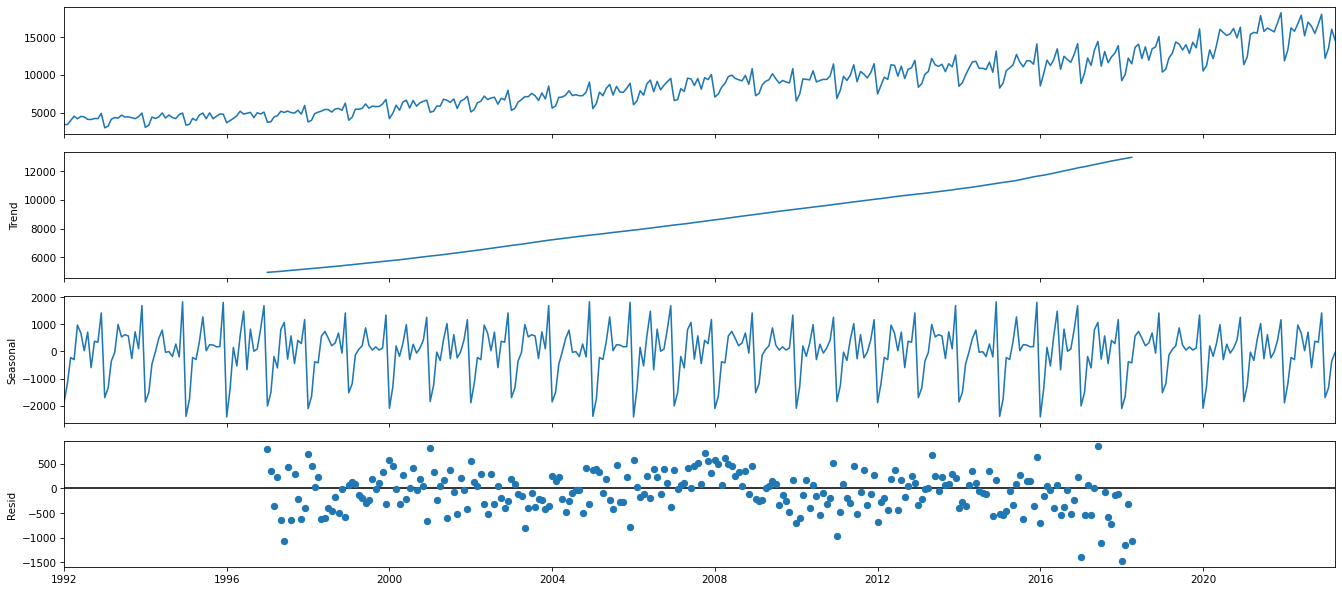

In [4]:
plt.rcParams.update({'figure.figsize':(18,8), 'figure.dpi':75})
result = seasonal_decompose(data, model='additive', period=120)
result.plot()
plt.show()

#### Note:


Based on these graphs, it is evident that there is a consistent upward trend in the number of alcoholic beverage sales over time. Additionally, there are recurring patterns of increase and decrease in values each year, indicating seasonal variations.

In [5]:
def plot_alcohol_volumes(df: pd.DataFrame, y: str) -> None:
    """General function for plotting the gold price over the years."""
    fig = px.line(df, x=df.index, y=y, labels={'Value': 'Millions of Dollars', 'Date': 'Time'})
    fig.update_layout(template="simple_white", font=dict(size=18), title_text='Alcohol Sales',
                      width=650, title_x=0.5, height=400)

    return fig.show()

plot_alcohol_volumes(df=data, y="Value")

The time series exhibits a distinct trend and noticeable yearly seasonality that gradually intensifies over time. Consequently, we must render it stationary by implementing differencing and employing the Box-Cox transformation technique.

In [6]:
# Make the target stationary
data['Value_boxcox'], lam = boxcox(data['Value'])
data["Value_stationary"] = data["Value_boxcox"].diff()
data.dropna(inplace=True)

# Plot the stationary airline passenger data
plot_alcohol_volumes(df=data, y="Value_stationary")

The time series appears to have achieved stationarity; nevertheless, we can validate this more quantitatively by employing the ADF test. 

To explain what it means for data to be stationary, I show the below image [3]. 

In [7]:
display(Image(url=img_url))

In [8]:
# Perform Augmented Dickey-Fuller test
# H0: The time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time
# HA: The time series is stationary.
print('ADF Statistic: ', adfuller(data['Value_stationary'])[0])
print('P-Value: ', adfuller(data['Value_stationary'])[1])

ADF Statistic:  -4.655785478429015
P-Value:  0.00010180847557212415


Here’s how to interpret the most important values in the output:
1. Test static: -4.655785478429018
2. P-value: 0.00010180847557212291

The P-Value is below 5%, so there is reason to reject the null hypothesis and we can say that the time series is satisfactory stationary.

---

### 4. Order selection

Determine the appropriate order (p) for the AR model. This can be achieved through techniques such as autocorrelation function (ACF) and partial autocorrelation function (PACF) plots, information criteria (e.g., AIC, BIC), or other model selection methods.

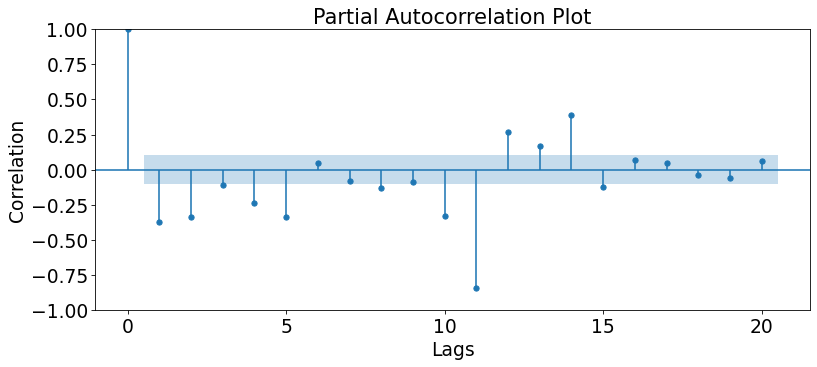

In [9]:
# Plot partial autocorrelation
plt.rc("figure", figsize=(11,5))
plot_pacf(data['Value_stationary'], method='ywm', lags=20)
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Correlation', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Partial Autocorrelation Plot', fontsize=20)
plt.tight_layout()
plt.show()

The following plot can be used to determine the order of AR model. You may note that a correlation value up to order 11 is high enough. Thus, we will train the AR model of order 11.

In [10]:
lag_order = 11

---

### 5. Model training

Utilize the AR class from the statsmodels.tsa package to train the AR model with the chosen order (p). Fit the model to the prepared dataset and estimate the model parameters.

In [11]:
data.index = pd.DatetimeIndex(data.index.values,
                               freq=data.index.inferred_freq)

# Split train and test
train = data.iloc[:-int(len(data) * 0.2)]
test = data.iloc[-int(len(data) * 0.2):]

# Build AR model
selector = ar_select_order(train['Value_stationary'], lag_order)
model = AutoReg(train['Value_stationary'], lags=selector.ar_lags).fit()

---

### 6. Model evaluation

Assess the performance of the trained AR model. This may involve examining diagnostic plots, evaluating model residuals, and computing relevant metrics such as mean squared error (MSE), Akaike information criterion (AIC), or others.

In [12]:
# Get forecasts and convert to actual passenger volumes
transformed_forecasts = list(model.forecast(steps=len(test)))
boxcox_forecasts = []
for idx in range(len(test)):
    if idx == 0:
        boxcox_forecast = transformed_forecasts[idx] + train['Value_boxcox'].iloc[-1]
    else:
        boxcox_forecast = transformed_forecasts[idx] + boxcox_forecasts[idx-1]

    boxcox_forecasts.append(boxcox_forecast)

forecasts = inv_boxcox(boxcox_forecasts, lam)


def plot_forecasts(forecasts: list[float],
                   title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train.index, y=train['Value'], name='Train'))
    fig.add_trace(go.Scatter(x=test.index, y=test['Value'], name='Test'))
    fig.add_trace(go.Scatter(x=test.index, y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Value Volume')

    return fig.show()


# Plot the forecasts
plot_forecasts(forecasts, 'Autoregression')

In [13]:
rmse_value = sqrt(mean_squared_error(test['Value'].to_numpy(), forecasts))
print("RMSE: ", rmse_value)

RMSE:  1602.608204442735


In [14]:
def dynamic_threshold(actual_data, forecast_data, rmse_value, multiplier):
    """A function that calculates a threshold based on the multiplier of the standard deviation of RMSE errors."""
    std_dev = np.std(actual_data - forecast_data)
    threshold = rmse_value + multiplier * std_dev
    return threshold

In [15]:
threshold_value = dynamic_threshold(test['Value'].to_numpy(), forecasts, rmse_value, multiplier=2)
print(f"The dynamically determined threshold is: {threshold_value}")

The dynamically determined threshold is: 4687.166912207009


In [16]:
# We check whether the error is large compared to a dynamically determined threshold
if rmse_value > threshold_value:
    print("The RMSE error is considered to be LARGE.")
else:
    print("The RMSE error is considered acceptable.")

The RMSE error is considered acceptable.


---

### 7. Forecasting

Utilize the trained AR model to generate future predictions or forecasts based on the available data. Evaluate the forecasted results and compare them to the actual values.

In [17]:
final_model=ExponentialSmoothing(data["Value"], trend='mul', seasonal='mul', seasonal_periods=12).fit(method='Powell')
final_prediction=final_model.forecast(36)

<Axes: >

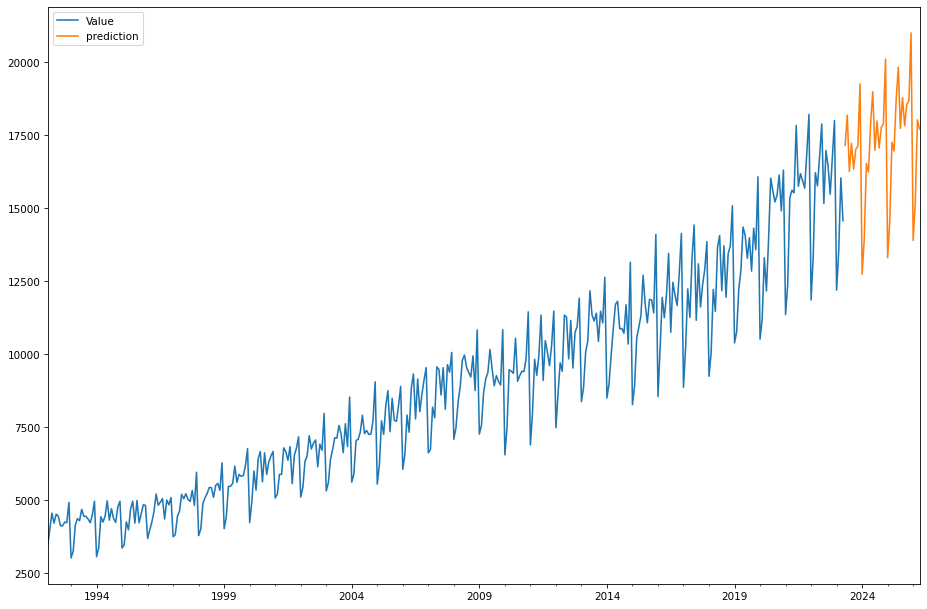

In [18]:
data["Value"].plot(figsize=(15,10),legend=True)
final_prediction.plot(label='prediction',legend=True)

In [19]:
final_prediction

2023-05-01    17152.172935
2023-06-01    18183.050857
2023-07-01    16261.504156
2023-08-01    17224.219044
2023-09-01    16340.767597
2023-10-01    17014.745583
2023-11-01    17124.992090
2023-12-01    19255.615828
2024-01-01    12745.308105
2024-02-01    13938.072234
2024-03-01    16527.964203
2024-04-01    16237.287203
2024-05-01    17912.333248
2024-06-01    18988.898238
2024-07-01    16982.191275
2024-08-01    17987.572340
2024-09-01    17064.967561
2024-10-01    17768.815309
2024-11-01    17883.947787
2024-12-01    20108.997788
2025-01-01    13310.162334
2025-02-01    14555.788100
2025-03-01    17260.460458
2025-04-01    16956.901061
2025-05-01    18706.182803
2025-06-01    19830.459647
2025-07-01    17734.818238
2025-08-01    18784.756387
2025-09-01    17821.263054
2025-10-01    18556.304349
2025-11-01    18676.539338
2025-12-01    21000.200443
2026-01-01    13900.050111
2026-02-01    15200.880269
2026-03-01    18025.419923
2026-04-01    17708.407198
Freq: MS, dtype: float64

### _Whether the above forecasts will come true, time will tell..._

#### I know that someone could have done it better but I think that by using AR I got a very good result.


## Cheers!

In [20]:
display(Image(url=gif_url))

---
---


### References and Further Reading
1. Zach, "Augmented Dickey-Fuller Test in Python (With Example)", https://www.statology.org/dickey-fuller-test-python/
2. Eryk Lewinson, "Time Series DIY: Seasonal Decomposition", https://towardsdatascience.com/time-series-diy-seasonal-decomposition-f0b469afed44
3. Jagan, "Time series Basics : Exploring traditional TS", https://www.kaggle.com/code/jagangupta/time-series-basics-exploring-traditional-ts